In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge

import xgboost as xgb

# 0) SETTINGS

In [2]:
CSV_PATH = r"C:\Users\YILMAZ\Desktop\machine_learning_2\ADANIPORTS.csv"

VOL_WINDOW = 21
ANNUALIZE = np.sqrt(252)

RET_THRESH = 0.30   # return clipping threshold
CAP_Q = 0.995       # cap volatility at train quantile

TEST_SIZE = 0.20
N_SPLITS_CV = 5     # for validation
RANDOM_STATE = 42

N_TRIALS = 50       # for tunning

# 1) LOAD DATA

In [3]:
df = pd.read_csv(CSV_PATH)

print("Raw shape:", df.shape)
print("Raw columns:", df.columns.tolist())

Raw shape: (3322, 15)
Raw columns: ['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble']


# 2) CLEANING

In [4]:
df = df.copy()
df.columns = [c.strip().replace("\n", " ") for c in df.columns]

if "Date" not in df.columns:
    raise ValueError("Column 'Date' not found.")

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

# Drop constant identifier columns (single asset)
for col in ["Symbol", "Series"]:
    if col in df.columns and df[col].nunique(dropna=True) <= 1:
        df = df.drop(columns=[col])

# Drop columns often redundant/noisy
df = df.drop(columns=["Last"], errors="ignore")
df = df.drop(columns=["Trades"], errors="ignore")

print("\nAfter basic cleaning ---> shape:", df.shape)
print("Columns:", df.columns.tolist())


After basic cleaning ---> shape: (3322, 12)
Columns: ['Date', 'Symbol', 'Prev Close', 'Open', 'High', 'Low', 'Close', 'VWAP', 'Volume', 'Turnover', 'Deliverable Volume', '%Deliverble']


# 3) NUMERIC CASTING

In [5]:
numeric_candidates = [
    "Prev Close", "Open", "High", "Low", "Close", "VWAP", "Volume",
    "Turnover", "Deliverable Volume", "%Deliverble", "%Deliverable"
]
for c in numeric_candidates:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Inspect missing-value rates after numeric conversion
na_rate = (df.isna().mean().sort_values(ascending=False) * 100).head(15)
print("\nTop missing columns (%):")
print(na_rate)


Top missing columns (%):
Date                  0.0
Symbol                0.0
Prev Close            0.0
Open                  0.0
High                  0.0
Low                   0.0
Close                 0.0
VWAP                  0.0
Volume                0.0
Turnover              0.0
Deliverable Volume    0.0
%Deliverble           0.0
dtype: float64


# 4) EDA 

In [6]:
print("\nDate range:", df["Date"].min(), "->", df["Date"].max())
print("Rows:", len(df))


Date range: 2007-11-27 00:00:00 -> 2021-04-30 00:00:00
Rows: 3322


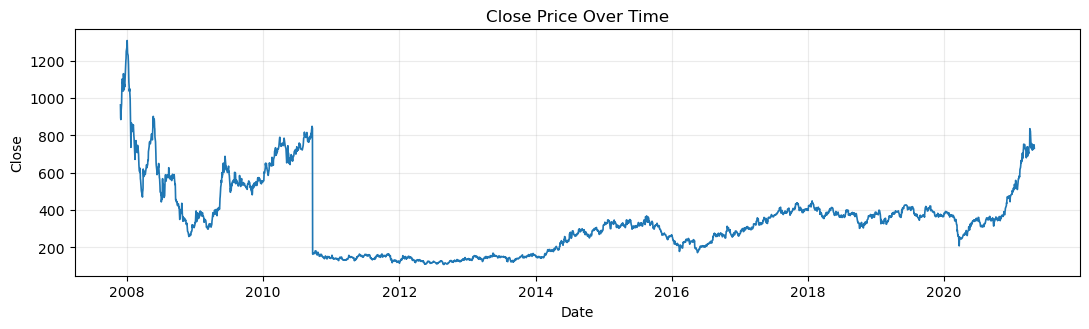

In [7]:
# Close price
if "Close" in df.columns:
    plt.figure(figsize=(11, 3.4))
    plt.plot(df["Date"], df["Close"], linewidth=1.2)
    plt.title("Close Price Over Time")
    plt.xlabel("Date")
    plt.ylabel("Close")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

- Price series contain trends and significant structural breaks in the long term. Therefore, it is more appropriate to work with yield and volatility-based variables rather than levels.

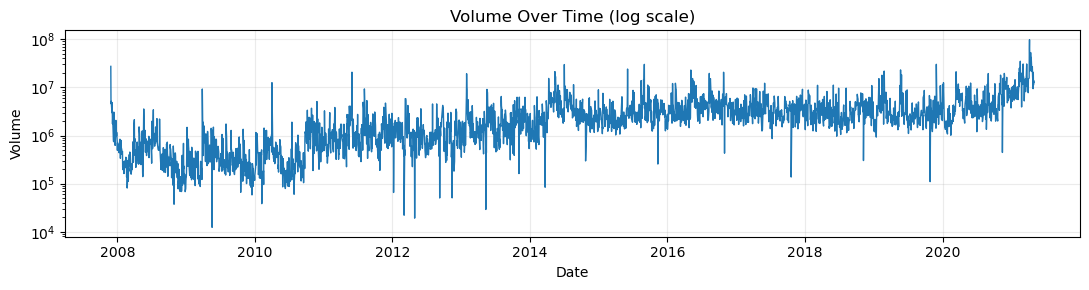

In [8]:
# Volume
if "Volume" in df.columns:
    plt.figure(figsize=(11, 3.0))
    plt.plot(df["Date"], df["Volume"], linewidth=1.0)
    plt.title("Volume Over Time (log scale)")
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.yscale("log")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

- Volume shows high volatility and sudden jumps, indicating changing liquidity regimes. Although noisy, it is a complementary source of information for volatility.

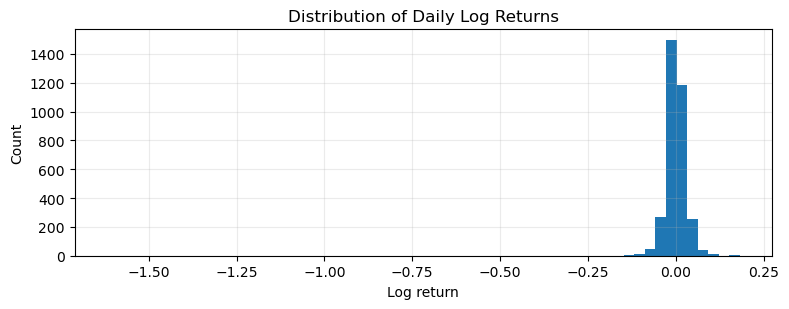

In [9]:
# Log return distribution
if "Close" in df.columns:
    tmp = df[["Close"]].copy()
    tmp["Log_Return"] = np.log(tmp["Close"] / tmp["Close"].shift(1))

    plt.figure(figsize=(8, 3.2))
    plt.hist(tmp["Log_Return"].dropna(), bins=60)
    plt.title("Distribution of Daily Log Returns")
    plt.xlabel("Log return")
    plt.ylabel("Count")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

- The distribution of daily log returns is concentrated around zero and exhibits distinctly thick tails. This reveals that financial return series deviate from a normal distribution and contain rare but extreme observations. This observation supports the rationale for applying clipping to log returns to prevent extreme returns from disproportionately affecting the calculation of realized volatility.

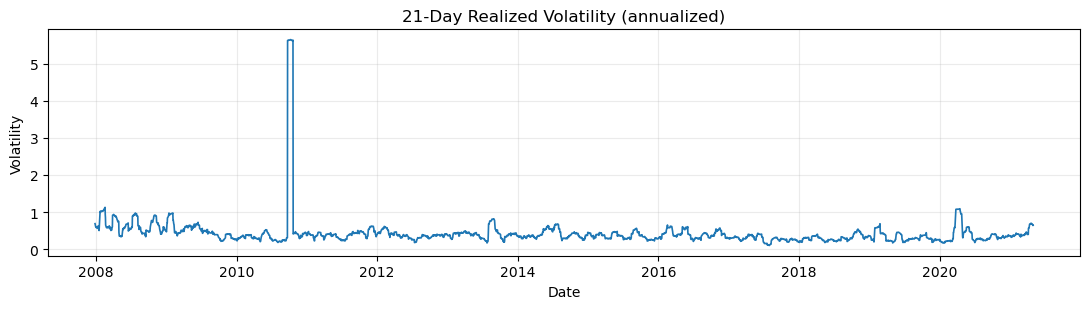

In [10]:
# 21-day(month) realized volatility time series
if "Close" in df.columns:
    tmp2 = df[["Date", "Close"]].copy()
    tmp2["Log_Return"] = np.log(tmp2["Close"] / tmp2["Close"].shift(1))
    tmp2["RV_21"] = tmp2["Log_Return"].rolling(21).std() * np.sqrt(252)

    plt.figure(figsize=(11, 3.2))
    plt.plot(tmp2["Date"], tmp2["RV_21"], linewidth=1.2)
    plt.title("21-Day Realized Volatility (annualized)")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

- The 21-day annualized realized volatility series shows significant volatility clustering and regime changes over time. Long periods of low volatility are interrupted by short but sharp volatility jumps, indicating that volatility is not stationary and varies over time. This structure confirms that the volatility estimation problem is meaningful and that the volatility capping approach is suitable for limiting the impact of extreme values ​​on the target variable.

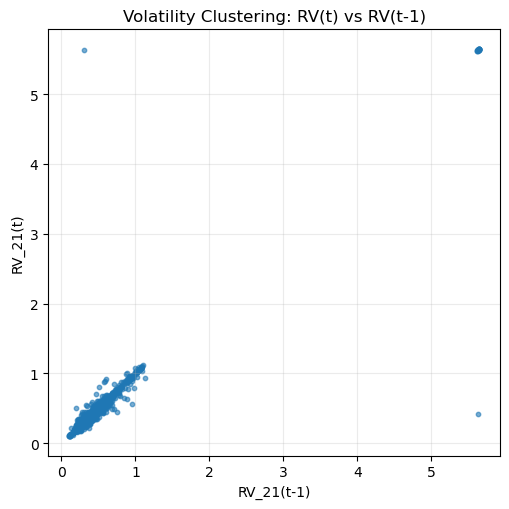

In [11]:
# Volatility clustering: RV(t) vs RV(t-1)
if "Close" in df.columns:
    tmp3 = tmp2.copy()
    tmp3["RV_21_lag1"] = tmp3["RV_21"].shift(1)
    scat = tmp3.dropna(subset=["RV_21", "RV_21_lag1"])

    plt.figure(figsize=(5.2, 5.2))
    plt.scatter(scat["RV_21_lag1"], scat["RV_21"], s=10, alpha=0.6)
    plt.xlabel("RV_21(t-1)")
    plt.ylabel("RV_21(t)")
    plt.title("Volatility Clustering: RV(t) vs RV(t-1)")
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

- Comparing the realized volatility values ​​for consecutive days clearly shows a strong and positive relationship between RV(t) and RV(t−1). The concentration of the points largely around the 45-degree line reveals that volatility is highly persistent and that current volatility strongly explains the volatility of the next day. This finding explains the high performance of the persistence benchmark model and visually confirms the dominant role of past volatility in volatility prediction.

# 5) RETURNS + BASE RV 

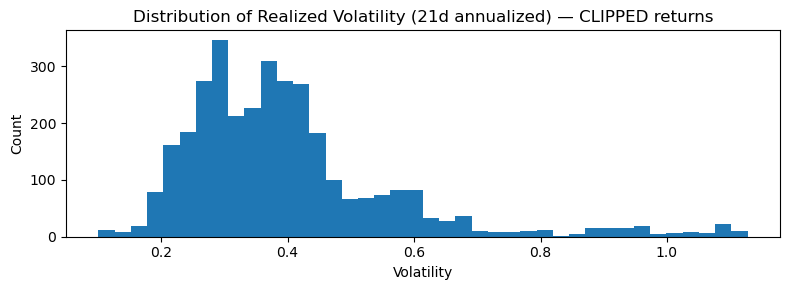

In [12]:
if "Close" not in df.columns:
    raise ValueError("'Close' is required.")

df["Log_Return_raw"] = np.log(df["Close"] / df["Close"].shift(1))

# DO NOT DROP ROWS >>> CLIP RETURNS
df["Log_Return"] = df["Log_Return_raw"].clip(-RET_THRESH, RET_THRESH)

# realized vol (based on clipped returns)
df["Volatility_raw"] = df["Log_Return_raw"].rolling(VOL_WINDOW).std() * ANNUALIZE
df["Volatility"] = df["Log_Return"].rolling(VOL_WINDOW).std() * ANNUALIZE

# quick plot
plt.figure(figsize=(8, 3))
plt.hist(df["Volatility"].dropna().values, bins=40)
plt.title("Distribution of Realized Volatility (21d annualized) — CLIPPED returns")
plt.xlabel("Volatility")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Daily Log Return
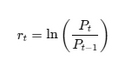

### 21-Day Realized Volatility
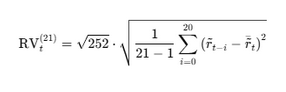

- Daily closing prices are first used to compute log returns, which represent the relative day-to-day price changes. Since financial return series often contain rare but extreme observations, return clipping (+/- 30) is applied to limit the impact of unusually large price movements without removing any observations from the dataset. This ensures that the time-series structure remains intact while preventing extreme returns from disproportionately inflating volatility estimates. Using these clipped returns, a 21-day rolling realized volatility series is then constructed and annualized. This procedure produces a more robust and stable volatility measure that still preserves the heavy-tailed nature of financial markets and provides a reliable target variable for volatility forecasting models.

# 6) FEATURE ENGINEERING 

In [13]:
# SMAs
df["SMA_20"] = df["Close"].rolling(window=20).mean()
df["SMA_50"] = df["Close"].rolling(window=50).mean()

# RSI(14)
window = 14
delta = df["Close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(window=window, min_periods=window).mean()
avg_loss = loss.rolling(window=window, min_periods=window).mean()

rs = avg_gain / avg_loss.replace(0, np.nan)
df["RSI_14"] = 100 - (100 / (1 + rs))

# ATR(14)
prev_close = df["Close"].shift(1)
tr1 = (df["High"] - df["Low"]).abs()
tr2 = (df["High"] - prev_close).abs()
tr3 = (df["Low"] - prev_close).abs()
tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
df["ATR_14"] = tr.rolling(window=14, min_periods=14).mean()

# Return lags
df["Ret_lag1"] = df["Log_Return"].shift(1)
df["Ret_lag2"] = df["Log_Return"].shift(2)

- This block creates technical and return-based features using only past data. Moving averages capture short- and medium-term price trends, RSI summarizes recent momentum, and ATR measures recent price variability as a proxy for market uncertainty. Lagged returns are added to reflect short-term dynamics and volatility clustering. All features rely on rolling windows and lags, ensuring no future information is used.
  
- Feature engineering was performed prior to the train–test split because all constructed features rely exclusively on historical information and rolling windows. This ensures the absence of look-ahead bias and guarantees consistent feature definitions across the training and test sets.

# 7) DEFINE THE FORECAST TARGET (1-day ahead)

In [14]:
# Target >>> 1-day ahead realized volatility
# y_t = Volatility(t+1), computed from past returns only

df["Target"] = df["Volatility"].shift(-1)
target_name = "Volatility_fwd1"

print("\nTarget definition:", target_name)


Target definition: Volatility_fwd1


- This block defines the forecasting target as one-day-ahead realized volatility. Specifically, the model uses information available up to time 
"𝑡" to predict the realized volatility at time "𝑡+1". The target is constructed by shifting the realized volatility series forward by one day, which creates a genuine out-of-sample forecasting setup.

# 8) BUILD MODELING DATASET + TIME SPLIT

In [15]:
# Select feature set used for modeling
feature_candidates = [
    "Prev Close", "Open", "High", "Low", "Close", "VWAP", "Volume",
    "SMA_20", "SMA_50", "RSI_14", "ATR_14", "Ret_lag1", "Ret_lag2"
]
# Keep only features that exist in the dataset
feature_cols = [c for c in feature_candidates if c in df.columns]

# Build modeling dataset by removing rows with missing target or features (if they have)
df_model = df.dropna(subset=["Target"]).copy()
df_model = df_model.dropna(subset=feature_cols).reset_index(drop=True)

# Separate inputs and target
X = df_model[feature_cols]
y = df_model["Target"]

# Time-based train–test split (no shuffling)
split_idx = int(len(df_model) * (1 - TEST_SIZE))
X_train, X_test = X.iloc[:split_idx].copy(), X.iloc[split_idx:].copy()
y_train, y_test = y.iloc[:split_idx].copy(), y.iloc[split_idx:].copy()

print("\nFeatures planned to be used:", feature_cols)
print("Train size:", len(X_train), "| Test size:", len(X_test))
print("Train period:", df_model["Date"].iloc[0], "->", df_model["Date"].iloc[split_idx-1])
print("Test period :", df_model["Date"].iloc[split_idx], "->", df_model["Date"].iloc[-1])


Features planned to be used: ['Prev Close', 'Open', 'High', 'Low', 'Close', 'VWAP', 'Volume', 'SMA_20', 'SMA_50', 'RSI_14', 'ATR_14', 'Ret_lag1', 'Ret_lag2']
Train size: 2617 | Test size: 655
Train period: 2008-02-06 00:00:00 -> 2018-08-31 00:00:00
Test period : 2018-09-03 00:00:00 -> 2021-04-29 00:00:00


# 9) TARGET CAPPING (Training-Only Quantile Clipping)

In [16]:
cap_val = np.quantile(y_train.dropna().values, CAP_Q)
y_train_cap = y_train.clip(upper=cap_val)
y_test_cap  = y_test.clip(upper=cap_val)

print(f"\nTarget capping: cap_q={CAP_Q} learned on TRAIN only, cap={cap_val:.6f}")


Target capping: cap_q=0.995 learned on TRAIN only, cap=1.098820


- In this step, extreme values of the target variable are capped at a high quantile determined exclusively from the training set. Learning the cap from the training data only prevents information leakage, while limiting the influence of rare and extreme volatility spikes.

# 10) BASELINE

In [17]:
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def metrics_pack(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred))
    }

In [18]:
# Mean baseline
mean_hat = float(y_train_cap.mean())

# Train
y_train_mean = np.full_like(y_train_cap.values, mean_hat, dtype=float)
mean_train_metrics = metrics_pack(y_train_cap.values, y_train_mean)

# Test
y_test_mean = np.full_like(y_test_cap.values, mean_hat, dtype=float)
mean_test_metrics = metrics_pack(y_test_cap.values, y_test_mean)

In [19]:
print("\nBASELINE — TRAIN SET")
print("-------------------------------------------")
print(f"Mean baseline        | RMSE={mean_train_metrics['RMSE']:.6f} "
      f"MAE={mean_train_metrics['MAE']:.6f} R2={mean_train_metrics['R2']:.4f}")

print("\nBASELINE — TEST SET")
print("-------------------------------------------")
print(f"Mean baseline        | RMSE={mean_test_metrics['RMSE']:.6f} "
      f"MAE={mean_test_metrics['MAE']:.6f} R2={mean_test_metrics['R2']:.4f}")


BASELINE — TRAIN SET
-------------------------------------------
Mean baseline        | RMSE=0.163541 MAE=0.115537 R2=0.0000

BASELINE — TEST SET
-------------------------------------------
Mean baseline        | RMSE=0.171520 MAE=0.128200 R2=-0.0610


# 11) OPTUNA: EXPANDING WINDOW CV — XGBOOST

In [20]:
# Expanding-window time-series cross-validation
tscv = TimeSeriesSplit(n_splits=N_SPLITS_CV)

# Optuna objective: minimize average RMSE across CV folds
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "random_state": RANDOM_STATE,
        "n_jobs": -1,

        "n_estimators": trial.suggest_int("n_estimators", 200, 1200),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),

        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),

        "min_child_weight": trial.suggest_float("min_child_weight", 1.0, 20.0),
        "gamma": trial.suggest_float("gamma", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 100.0, log=True),
    }

    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", xgb.XGBRegressor(**params))
    ])

    fold_rmses = []
    for tr_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train_cap.iloc[tr_idx], y_train_cap.iloc[val_idx]

        pipe.fit(X_tr, y_tr)
        y_val_pred = pipe.predict(X_val)
        fold_rmses.append(rmse(y_val, y_val_pred))

    return float(np.mean(fold_rmses))

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n==============================")
print("OPTUNA (EXPANDING WINDOW CV) — XGBOOST")
print("==============================")
print("Best CV RMSE:", study.best_value)
print("Best params:", study.best_params)

[I 2026-01-07 22:04:42,697] A new study created in memory with name: no-name-c0d123ab-0a87-479a-b4eb-3a48dc477328


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-01-07 22:04:44,215] Trial 0 finished with value: 0.14641776304979748 and parameters: {'n_estimators': 1198, 'max_depth': 2, 'learning_rate': 0.018801375102249815, 'subsample': 0.7761866011356346, 'colsample_bytree': 0.9719154969324975, 'min_child_weight': 7.905291227264284, 'gamma': 1.6135281632500125, 'reg_lambda': 0.0027367391199529336}. Best is trial 0 with value: 0.14641776304979748.
[I 2026-01-07 22:04:44,697] Trial 1 finished with value: 0.14633498211863732 and parameters: {'n_estimators': 432, 'max_depth': 5, 'learning_rate': 0.04364170267595556, 'subsample': 0.7522566949021982, 'colsample_bytree': 0.8008445593216839, 'min_child_weight': 2.0956531853481133, 'gamma': 1.7238427980092768, 'reg_lambda': 0.03454978597997718}. Best is trial 1 with value: 0.14633498211863732.
[I 2026-01-07 22:04:45,080] Trial 2 finished with value: 0.1411148889848081 and parameters: {'n_estimators': 253, 'max_depth': 7, 'learning_rate': 0.029489471854723646, 'subsample': 0.6989417852804072, 'co

# 12) FINAL TRAIN ON FULL TRAIN, EVAL ON TEST

In [21]:
# Train final XGBoost model using best hyperparameters from Optuna
best_params = study.best_params.copy()
best_params.update({
    "objective": "reg:squarederror",
    "random_state": RANDOM_STATE,
    "n_jobs": -1
})

# Pipeline: median imputation + tuned XGBoost model
xgb_best = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", xgb.XGBRegressor(**best_params))
])

# Fit model on full training set
xgb_best.fit(X_train, y_train_cap)

# Generate predictions on train and test sets
y_train_pred = xgb_best.predict(X_train)
y_test_pred  = xgb_best.predict(X_test)

y_train_m = metrics_pack(y_train_cap, y_train_pred)
y_test_m  = metrics_pack(y_test_cap, y_test_pred)

print("\nXGBoost Model")
print("-------------------------------------------")
print("TRAIN SET")
print(f"  RMSE: {y_train_m['RMSE']:.6f}")
print(f"  MAE : {y_train_m['MAE']:.6f}")
print(f"  R²  : {y_train_m['R2']:.4f}")
print("-----------------------")
print("TEST SET")
print(f"  RMSE: {y_test_m['RMSE']:.6f}")
print(f"  MAE : {y_test_m['MAE']:.6f}")
print(f"  R²  : {y_test_m['R2']:.4f}")


XGBoost Model
-------------------------------------------
TRAIN SET
  RMSE: 0.073863
  MAE : 0.051911
  R²  : 0.7960
-----------------------
TEST SET
  RMSE: 0.104402
  MAE : 0.069523
  R²  : 0.6069


# 13) FEATURE IMPORTANCE (gain)

In [22]:
# Extract trained XGBoost model from the pipeline
xgb_model = xgb_best.named_steps["model"]
booster = xgb_model.get_booster()

# Compute feature importance based on average gain
imp_gain = booster.get_score(importance_type="gain")
imp_df = pd.DataFrame({
    "feature": list(imp_gain.keys()),
    "gain": list(imp_gain.values())
}).sort_values("gain", ascending=False)

feature_map = {f"f{i}": name for i, name in enumerate(feature_cols)}
imp_df["feature_name"] = imp_df["feature"].map(feature_map).fillna(imp_df["feature"])

print("\nTop feature importances (gain):")
print(imp_df[["feature_name", "gain"]].head(15).to_string(index=False))


Top feature importances (gain):
feature_name     gain
      ATR_14 1.808082
        High 1.728531
        VWAP 1.430956
       Close 1.228688
         Low 1.036853
  Prev Close 0.894316
    Ret_lag2 0.800246
      SMA_50 0.657122
      SMA_20 0.570808
        Open 0.555384
    Ret_lag1 0.413018
      RSI_14 0.402195


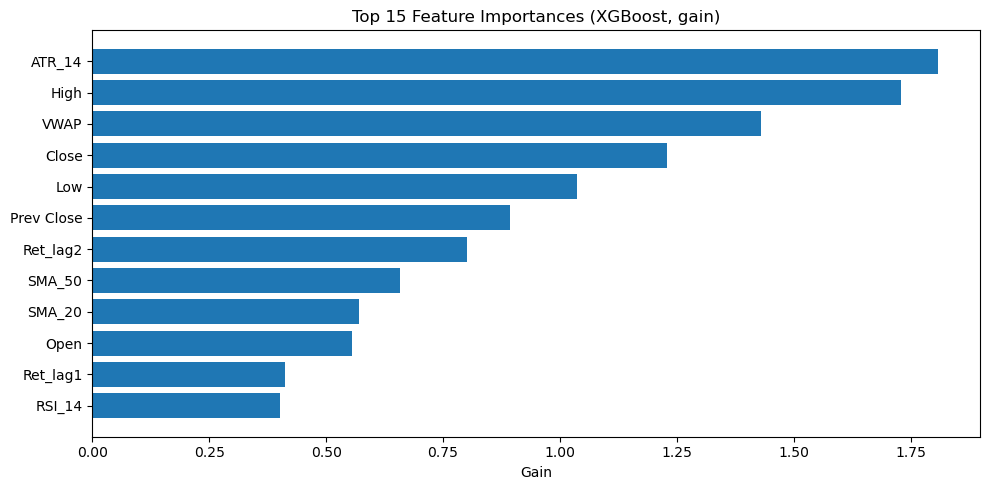

In [23]:
plt.figure(figsize=(10, 5))
top_n = 15
top = imp_df.head(top_n).iloc[::-1]
plt.barh(top["feature_name"], top["gain"])
plt.title(f"Top {top_n} Feature Importances (XGBoost, gain)")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()

# 14) ACTUAL vs PREDICTED (TEST) + RESIDUALS

In [24]:
# Create a testset dataframe for analysis and visualization
preds_test = df_model.iloc[split_idx:].copy().reset_index(drop=True)

# Store actual target values, model predictions, and residuals
preds_test["y_true"] = y_test_cap.values
preds_test["y_pred"] = y_test_pred
preds_test["residual"] = preds_test["y_true"] - preds_test["y_pred"]

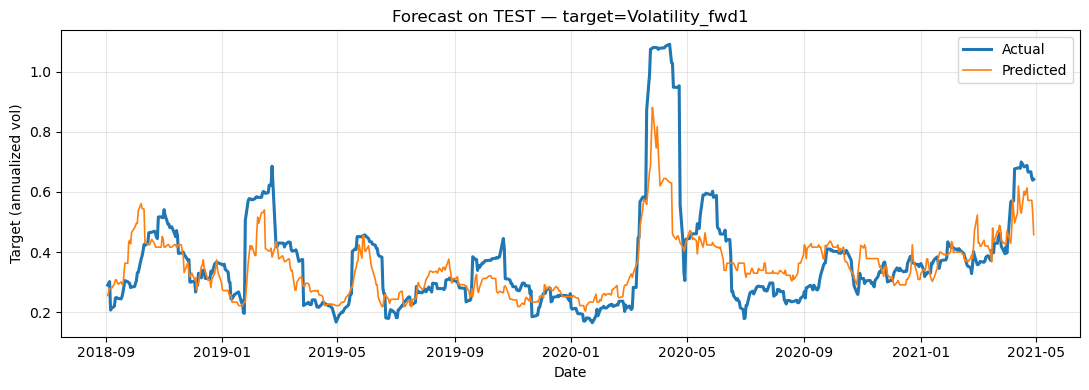

In [25]:
plt.figure(figsize=(11, 4))
plt.plot(preds_test["Date"], preds_test["y_true"], label="Actual", linewidth=2.2)
plt.plot(preds_test["Date"], preds_test["y_pred"], label="Predicted", linewidth=1.2)
plt.title(f"Forecast on TEST — target={target_name}")
plt.xlabel("Date")
plt.ylabel("Target (annualized vol)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

- While the model successfully tracks the overall level of realized volatility and regime changes over time, it tends to underestimate sudden and very sharp volatility jumps.

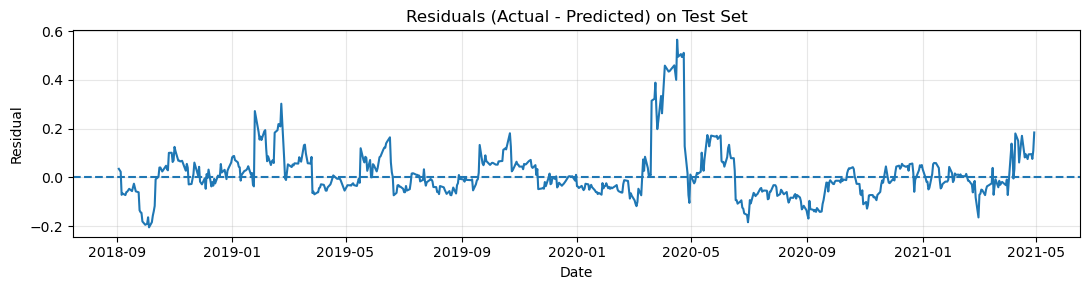

In [26]:
plt.figure(figsize=(11, 3))
plt.plot(preds_test["Date"], preds_test["residual"], linewidth=1.5)
plt.axhline(0, linestyle="--")
plt.title("Residuals (Actual - Predicted) on Test Set")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

- The residuals mostly fluctuate around zero, and the significant deviations observed during crisis periods indicate that the model struggles to accurately capture extreme volatility events.

In [27]:
print("\nPred preview:")
print(preds_test[["Date", "y_true", "y_pred", "residual"]].head(10))


Pred preview:
        Date    y_true    y_pred  residual
0 2018-09-03  0.290187  0.255527  0.034660
1 2018-09-04  0.296294  0.267631  0.028664
2 2018-09-05  0.301887  0.279151  0.022736
3 2018-09-06  0.207121  0.279151 -0.072029
4 2018-09-07  0.212648  0.279151 -0.066503
5 2018-09-10  0.219990  0.293048 -0.073058
6 2018-09-11  0.246817  0.307639 -0.060822
7 2018-09-12  0.248929  0.307639 -0.058710
8 2018-09-14  0.245693  0.293048 -0.047355
9 2018-09-17  0.244218  0.300853 -0.056635
